In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Show One Example of Dataset

2024-05-05 22:06:28,794 - notebook_logger - INFO - Image ID:, 2000000283210
2024-05-05 22:06:28,794 - notebook_logger - INFO - **************************************************
2024-05-05 22:06:28,795 - notebook_logger - INFO - Categories: ['dog', 'chair']
2024-05-05 22:06:28,795 - notebook_logger - INFO - Super Categories: ['animal', 'furniture']
2024-05-05 22:06:28,795 - notebook_logger - INFO - **************************************************
2024-05-05 22:06:28,796 - notebook_logger - INFO - S1: hello how are you today ?
2024-05-05 22:06:28,796 - notebook_logger - INFO - S2: hi , my husband is old and adopted . i love coloring farms in books .
2024-05-05 22:06:28,796 - notebook_logger - INFO - S1: ok that is random . i have never been an artist type
2024-05-05 22:06:28,797 - notebook_logger - INFO - S2: great ! i live on a farm with a dog named trump who watches hockey .
2024-05-05 22:06:28,797 - notebook_logger - INFO - S1: i do not care for dogs . i am waiting for retirement
2

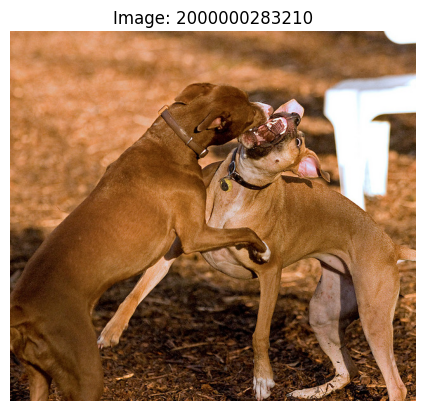

2024-05-05 22:06:29,004 - notebook_logger - INFO - **************************************************
2024-05-05 22:06:29,326 - notebook_logger - INFO - person CLIP feature similarity: 0.2144775390625
2024-05-05 22:06:29,337 - notebook_logger - INFO - animal CLIP feature similarity: 0.2423095703125
2024-05-05 22:06:29,349 - notebook_logger - INFO - vehicle CLIP feature similarity: 0.153564453125
2024-05-05 22:06:29,362 - notebook_logger - INFO - outdoor CLIP feature similarity: 0.179931640625
2024-05-05 22:06:29,380 - notebook_logger - INFO - accessory CLIP feature similarity: 0.2186279296875
2024-05-05 22:06:29,393 - notebook_logger - INFO - sports CLIP feature similarity: 0.2115478515625
2024-05-05 22:06:29,447 - notebook_logger - INFO - kitchen CLIP feature similarity: 0.211669921875
2024-05-05 22:06:29,459 - notebook_logger - INFO - food CLIP feature similarity: 0.1580810546875
2024-05-05 22:06:29,472 - notebook_logger - INFO - furniture CLIP feature similarity: 0.1759033203125
202

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "real", logger=logger)
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

# Define OOD Categories below

In [5]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

OOD
0    16461
1      519
Name: count, dtype: int64

# Load CLIP features for images and dialogues with Model CLIP ViT-B32

In [6]:
## Dialogue Processing
dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
df_table['dialogue_clip'] = list(dialogue_clip)

## Image Processing
image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
image_annotation.rename(columns={0:"image_clip"}, inplace=True)
df_table = df_table.merge(image_annotation, on='img_file', how='left')

In [7]:
dialogue_df_segment = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_expand_dialog.json')
dialogue_clip_segment = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_segment/new_mmd_dialog_features.npy')
dialogue_df_segment['dialogue_clip'] = list(dialogue_clip_segment)

In [8]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [9]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

if data_loader.data_source == "qa":
    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += cosine_sim_current
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)


    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))
dialogue_df_segment['dialogue_score'], dialogue_df_segment['dialogue_score_max'] = zip(*dialogue_df_segment.progress_apply(calculate_similarity_score, type = "dialogue", axis=1))
df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/16980 [00:00<?, ?it/s]

  0%|          | 0/61810 [00:00<?, ?it/s]

  0%|          | 0/16980 [00:00<?, ?it/s]

In [10]:
df_table['dialogue_score_segment'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score'].mean())['dialogue_score'].values
df_table['dialogue_score_segment_max'] = pd.DataFrame(dialogue_df_segment.groupby('index')['dialogue_score_max'].mean())['dialogue_score_max'].values

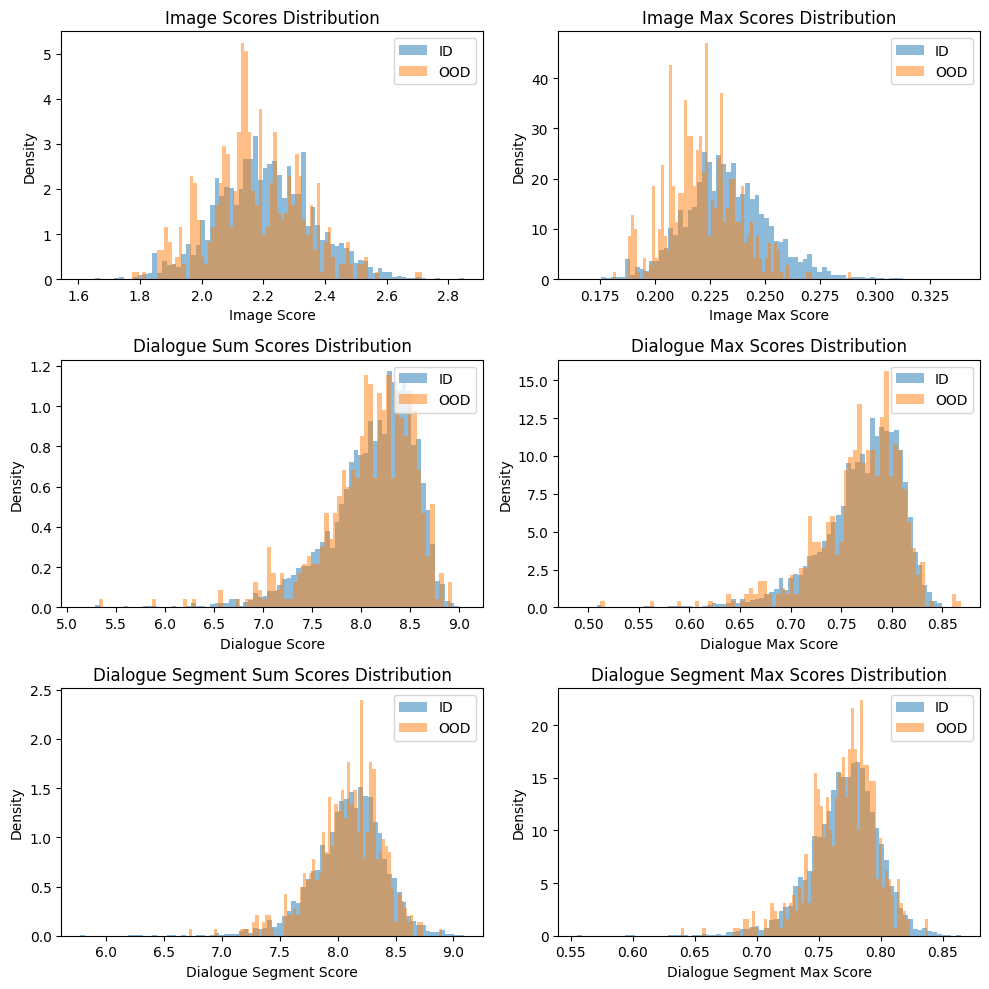

In [11]:
import matplotlib.pyplot as plt

# Assuming df_table is preloaded with the appropriate columns
# Simplifying the code and plotting all histograms in a 2x2 layout

# Create figure and axes for a 2x2 grid
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Data for histograms
columns = ['image_score', 'image_score_max', 'dialogue_score', 'dialogue_score_max', 'dialogue_score_segment', 'dialogue_score_segment_max']
titles = ['Image Scores Distribution', 'Image Max Scores Distribution',
          'Dialogue Sum Scores Distribution', 'Dialogue Max Scores Distribution',
          'Dialogue Segment Sum Scores Distribution', 'Dialogue Segment Max Scores Distribution']
x_labels = ['Image Score', 'Image Max Score', 'Dialogue Score', 'Dialogue Max Score', 'Dialogue Segment Score', 'Dialogue Segment Max Score']

# Loop through to plot each histogram in its subplot
for i, ax in enumerate(axs.flatten()):
    ood_scores = df_table[df_table['OOD'] == 1][columns[i]]
    non_ood_scores = df_table[df_table['OOD'] == 0][columns[i]]
    ax.hist(non_ood_scores, bins=80, alpha=0.5, label='ID', density=True)
    ax.hist(ood_scores, bins=80, alpha=0.5, label='OOD', density=True)
    ax.legend(loc='upper right')
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [12]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from 'f:\\Github\\multimodal_ood\\utils\\evaluation.py'>

In [13]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score_max'] + 0.0001*df_table['dialogue_score_max'])
df_table['overall_simialrity_sum'] = df_table['image_text_similarity'] * (df_table['image_score'] + 0.0001*df_table['dialogue_score'])

In [14]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score'].values, 0.95))
print('Dialogue Segment Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment_max'].values, 0.95))
print('Dialogue Segment Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_segment'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity'].values, 0.95))
print("Overall Sum:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity_sum'].values, 0.95))

Image Max: 0.8250410060142154
Image Sum: 0.9034688050543709
Dialogue Max: 0.9461150598384059
Dialogue Sum: 0.9527367717635623
Dialogue Segment Max: 0.9383391045501488
Dialogue Segment Sum: 0.9326286373853351
Overall Max: 0.8195127878014702
Overall Sum: 0.8804446874430472


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from models.DNN import model 

image_model_loader = model.model_loader(logger=logger,
                                  num_epochs=15)

dialogue_model_loader = model.model_loader(logger=logger,
                                    num_epochs=15,
                                    learning_rate=0.001)

2024-05-05 22:06:49,456 - notebook_logger - INFO - Setting random seed: 42
2024-05-05 22:06:49,459 - notebook_logger - INFO - Setting random seed: 42


In [16]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = image_model_loader.create_dataset(data_loader, df_table)


In [17]:
image_model_loader.train_model(X_train_image, Y_train)

100%|██████████| 15/15 [00:20<00:00,  1.36s/it]


In [18]:
dialogue_model_loader.train_model(X_train_dialogue, Y_train)

100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


In [25]:
score_type_list = ["mp", "energy", "maxlogits", "msp"]

for score_type in score_type_list:
    image_score_sum, image_score_max = image_model_loader.evaluate_on_test(X_test_image, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    dialogue_score_sum, dialogue_score_max = dialogue_model_loader.evaluate_on_test(X_test_dialogue, 
                                                        Y_test,
                                                        score_type=score_type,\
                                                        return_score=True)
    
    df_test[f'{score_type}_sum_image'] = image_score_sum
    df_test[f'{score_type}_max_image'] = image_score_max
    df_test[f'{score_type}_sum_dialogue'] = dialogue_score_sum
    df_test[f'{score_type}_max_dialogue'] = dialogue_score_max
    df_test[f'{score_type}_overall_simialrity'] = df_test['image_text_similarity'] * (df_test[f'{score_type}_max_image'] + df_test[f'{score_type}_max_dialogue'])
    if score_type == "energy":
        df_test[f'{score_type}_overall_simialrity_sum'] = df_test['image_text_similarity'] * (df_test[f'{score_type}_sum_image'] + df_test[f'{score_type}_sum_dialogue'])

2024-05-05 22:33:48,410 - notebook_logger - INFO - Test Loss: 0.1497, Test Accuracy: 0.7311
2024-05-05 22:33:48,480 - notebook_logger - INFO - Test Loss: 0.4509, Test Accuracy: 0.0763
2024-05-05 22:33:48,557 - notebook_logger - INFO - Test Loss: 0.1497, Test Accuracy: 0.7311
2024-05-05 22:33:48,635 - notebook_logger - INFO - Test Loss: 0.4509, Test Accuracy: 0.0763
2024-05-05 22:33:48,762 - notebook_logger - INFO - Test Loss: 0.1497, Test Accuracy: 0.7311
2024-05-05 22:33:48,840 - notebook_logger - INFO - Test Loss: 0.4509, Test Accuracy: 0.0763
2024-05-05 22:33:48,918 - notebook_logger - INFO - Test Loss: 0.1497, Test Accuracy: 0.7311
2024-05-05 22:33:48,994 - notebook_logger - INFO - Test Loss: 0.4509, Test Accuracy: 0.0763


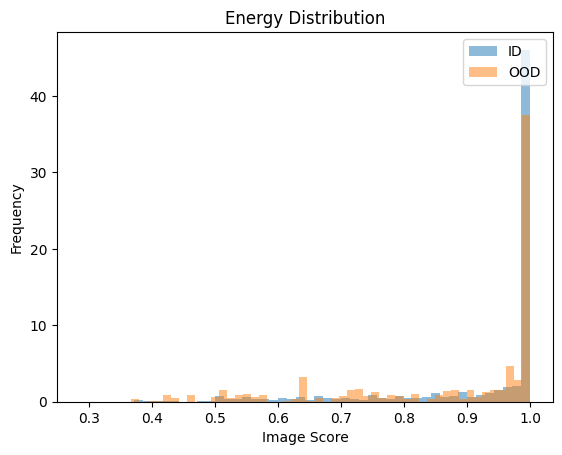

In [20]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_max_image']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_max_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

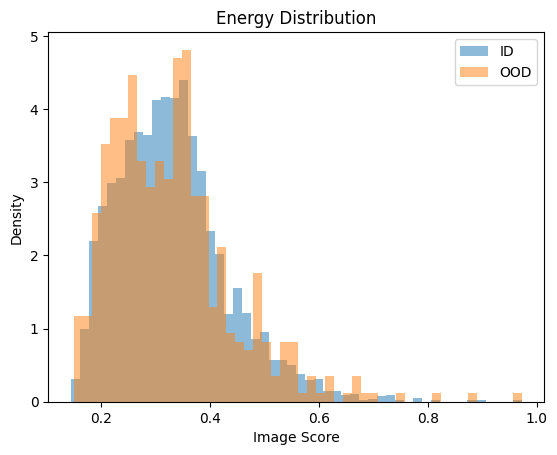

In [21]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_max_dialogue']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_max_dialogue']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Density')

plt.show()

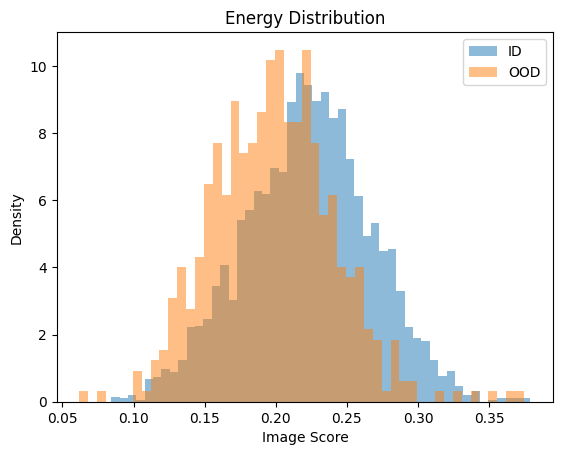

In [22]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1][f'{score_type}_overall_simialrity']
non_ood_scores = df_test[df_test['OOD'] == 0][f'{score_type}_overall_simialrity']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID', density = 1)
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD', density = 1)
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Density')

plt.show()

In [23]:
logger.info("Image Max:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['image_score_max'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['image_score_max'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['image_score_max'].values))
###
logger.info("#"*50)
logger.info("Image Sum:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['image_score'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['image_score'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['image_score'].values))
###
logger.info("#"*50)
logger.info("Dialogue Max:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_max'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['dialogue_score_max'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_max'].values))
###
logger.info("#"*50)
logger.info("Dialogue Sum:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['dialogue_score'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['dialogue_score'].values))
###
logger.info("#"*50)
logger.info("Dialogue Segment Max:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment_max'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment_max'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment_max'].values))
###
logger.info("#"*50)
logger.info("Dialogue Segment Sum:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['dialogue_score_segment'].values))
###
logger.info("#"*50)
logger.info("Overall Max:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['overall_simialrity'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['overall_simialrity'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['overall_simialrity'].values))
###
logger.info("#"*50)
logger.info("Overall Sum:")
logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test['overall_simialrity_sum'].values, 0.95))
logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test['overall_simialrity_sum'].values))
logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test['overall_simialrity_sum'].values))

2024-05-05 22:07:32,853 - notebook_logger - INFO - Image Max:
2024-05-05 22:07:32,855 - notebook_logger - INFO - 0.818955042527339
2024-05-05 22:07:32,893 - notebook_logger - INFO - 0.6801518014126615
2024-05-05 22:07:32,895 - notebook_logger - INFO - 0.2277642557136374
2024-05-05 22:07:32,895 - notebook_logger - INFO - ##################################################
2024-05-05 22:07:32,896 - notebook_logger - INFO - Image Sum:
2024-05-05 22:07:32,897 - notebook_logger - INFO - 0.9070473876063183
2024-05-05 22:07:32,899 - notebook_logger - INFO - 0.5596301654972526
2024-05-05 22:07:32,900 - notebook_logger - INFO - 0.16089235960859943
2024-05-05 22:07:32,901 - notebook_logger - INFO - ##################################################
2024-05-05 22:07:32,901 - notebook_logger - INFO - Dialogue Max:
2024-05-05 22:07:32,902 - notebook_logger - INFO - 0.93955042527339
2024-05-05 22:07:32,903 - notebook_logger - INFO - 0.5269117402613213
2024-05-05 22:07:32,906 - notebook_logger - INFO 

In [26]:

for score_type in score_type_list:

    logger.info(f"Score Type: {score_type}")
    if score_type == "energy":
        logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_sum_image'].values, 0.95))
        logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_sum_image'].values))
        logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_sum_image'].values))
        logger.info("#"*50)
        logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_sum_dialogue'].values, 0.95))
        logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_sum_dialogue'].values))
        logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_sum_dialogue'].values))
        logger.info("#"*50)
        logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_overall_simialrity_sum'].values, 0.95))
        logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_overall_simialrity_sum'].values))
        logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_overall_simialrity_sum'].values))

    logger.info("#"*50)
    logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_image'].values, 0.95))
    logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_image'].values))
    logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_image'].values))
    ###
    logger.info("#"*50)
    logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_dialogue'].values, 0.95))
    logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_dialogue'].values))
    logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_max_dialogue'].values))
    ###
    logger.info("#"*50)
    logger.info(ev.fpr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_overall_simialrity'].values, 0.95))
    logger.info(ev.auroc_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_overall_simialrity'].values))
    logger.info(ev.aupr_evaluation(df_test['OOD'].values, -df_test[f'{score_type}_overall_simialrity'].values))
    logger.info("#"*50)

2024-05-05 22:36:42,923 - notebook_logger - INFO - Score Type: mp
2024-05-05 22:36:42,924 - notebook_logger - INFO - ##################################################
2024-05-05 22:36:42,925 - notebook_logger - INFO - 0.39003645200486026
2024-05-05 22:36:42,927 - notebook_logger - INFO - 0.9089141774184865
2024-05-05 22:36:42,928 - notebook_logger - INFO - 0.6828019614315921
2024-05-05 22:36:42,929 - notebook_logger - INFO - ##################################################
2024-05-05 22:36:42,930 - notebook_logger - INFO - 0.9592952612393681
2024-05-05 22:36:42,932 - notebook_logger - INFO - 0.5135190816997824
2024-05-05 22:36:42,933 - notebook_logger - INFO - 0.1509291196686525
2024-05-05 22:36:42,934 - notebook_logger - INFO - ##################################################
2024-05-05 22:36:42,935 - notebook_logger - INFO - 0.7569866342648846
2024-05-05 22:36:42,936 - notebook_logger - INFO - 0.7946320501384803
2024-05-05 22:36:42,938 - notebook_logger - INFO - 0.50724113825499